In [1]:
#Import required libraries
from sklearn.datasets import fetch_openml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
def load_data():
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser="auto")
    X, y = torch.from_numpy(X.to_numpy()).float(), torch.from_numpy(y.to_numpy().astype(np.uint8))
    print(X.shape, y.shape, X.dtype, y.dtype)
    return X, y

In [3]:
def train_test_split(raw_data, labels, split_index):
    """Split the original data into a training dataset
	and a testing dataset.

	Args:
		raw_data: An array of shape [n_samples, 784].
        labels : An array of shape [n_samples,].
		split_index: An integer.
    Returns:
        X_train, X_test, y_train, y_test(follow this order)

	"""
    ### YOUR CODE HERE
    X_train, X_test = raw_data[:split_index], raw_data[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return X_train, X_test, y_train, y_test
    ### END YOUR CODE

In [4]:
def prepare_X(raw_X):
    """Normalize raw_X as required.

    Args:
        raw_X: An array of shape [n_samples, 784].

    Returns:
        X: Normalized samples [n_samples, 784].
    """
	### YOUR CODE HERE
    return raw_X / 256
	### END YOUR CODE

torch.Size([70000, 784]) torch.Size([70000]) torch.float32 torch.uint8
Training with batch size: 1
Epoch [1/20], Iteration [5000], Loss: 0.4350
Epoch [1/20], Iteration [10000], Loss: 0.3767
Epoch [1/20], Iteration [15000], Loss: 0.3507
Epoch [1/20], Iteration [20000], Loss: 0.3451
Epoch [1/20], Iteration [25000], Loss: 0.3446
Epoch [1/20], Iteration [30000], Loss: 0.3340
Epoch [1/20], Iteration [35000], Loss: 0.3160
Epoch [1/20], Iteration [40000], Loss: 0.3219
Epoch [1/20], Iteration [45000], Loss: 0.3192
Epoch [1/20], Iteration [50000], Loss: 0.3126
Epoch [2/20], Iteration [55000], Loss: 0.3064
Epoch [2/20], Iteration [60000], Loss: 0.2955
Epoch [2/20], Iteration [65000], Loss: 0.2938
Epoch [2/20], Iteration [70000], Loss: 0.2985
Epoch [2/20], Iteration [75000], Loss: 0.2951
Epoch [2/20], Iteration [80000], Loss: 0.2979
Epoch [2/20], Iteration [85000], Loss: 0.2868
Epoch [2/20], Iteration [90000], Loss: 0.2919
Epoch [2/20], Iteration [95000], Loss: 0.2849
Epoch [2/20], Iteration [100

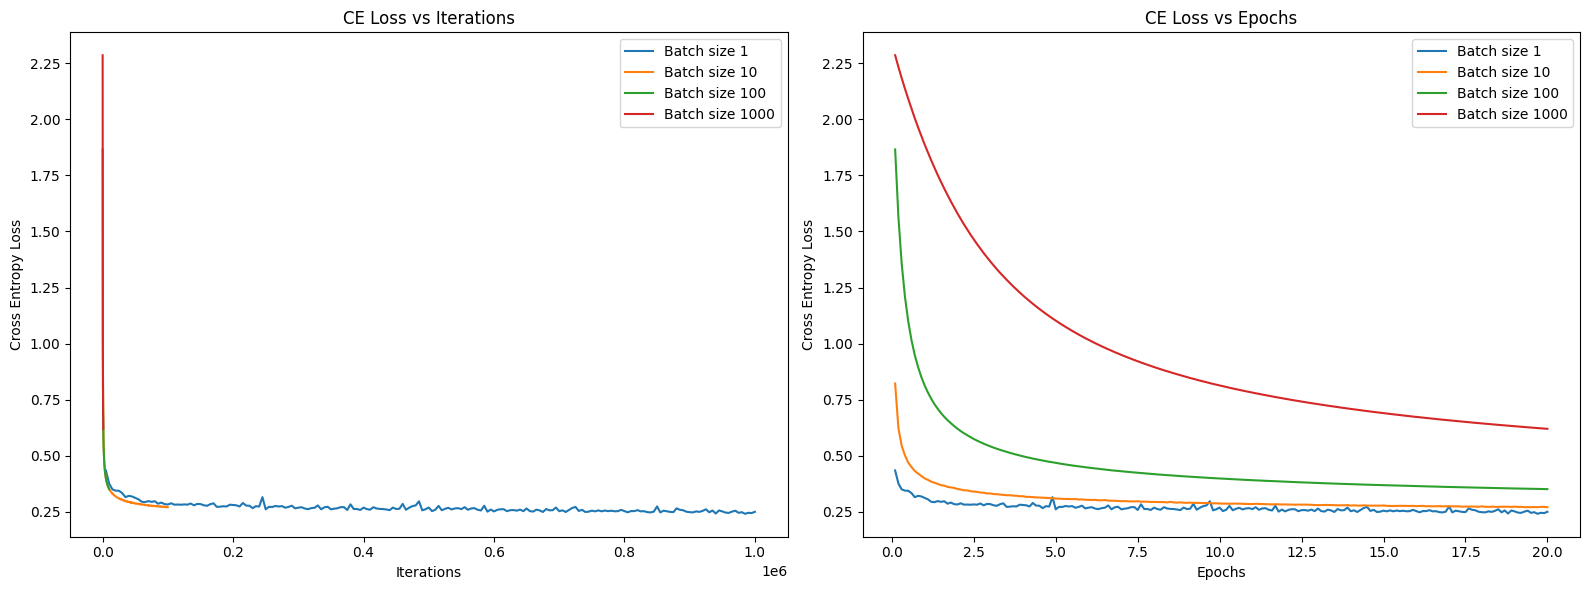

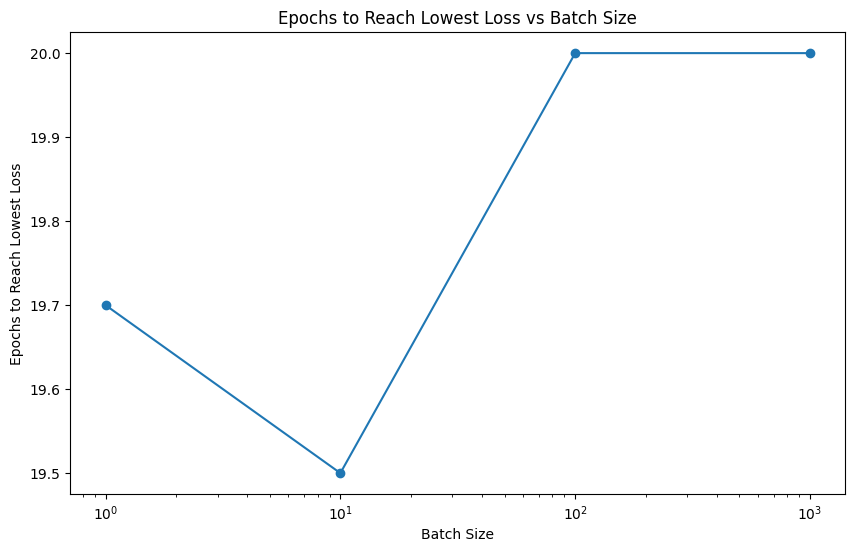

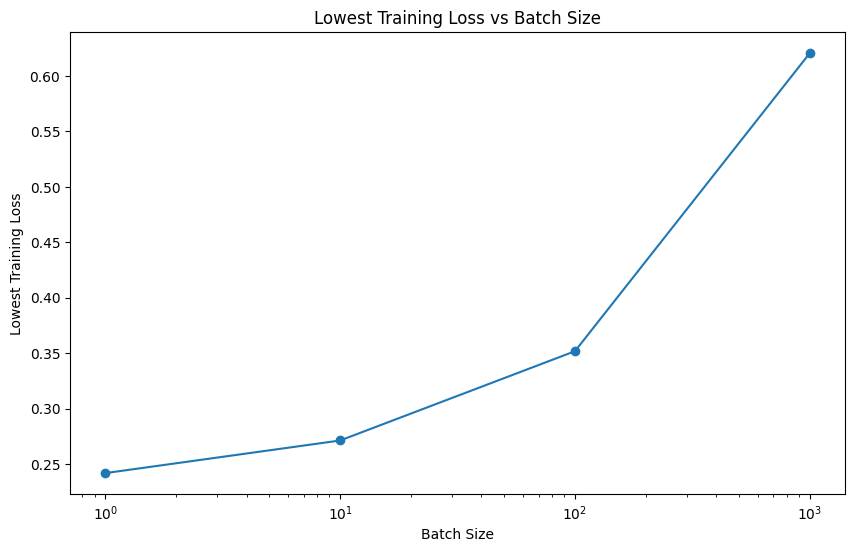

In [5]:
# --------------Model------------------#
#A simple linear MLR model
class MLR(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.classifer = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.classifer(x)

# --------------------Main function----------------------#

def main():
    # Hyperparameters
    input_size = 28 * 28  # 784, for flattened 28x28 MNIST images
    num_classes = 10  # Digits 0-9
    learning_rate = 0.01
    num_epochs = 20
    weight_decay = 0.0
    batch_sizes = [1, 10, 100, 1000] #changed batch size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #(use GPU if available, otherwise CPU)

    # Load and preprocess data
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, 60000) #first split original data into trainset and testset
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 50000) #then split trainset into trainset and valset
    X_train, X_val, X_test = prepare_X(X_train), prepare_X(X_val), prepare_X(X_test)
    results = {} #Dictionary to store batchsize, train loss, epochs, iterations)

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")

        # Create the Datasets
        trainset = TensorDataset(X_train, y_train)
        valset = TensorDataset(X_val, y_val)
        testset = TensorDataset(X_test, y_test)

        # Create the Dataloaders
        train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
        train_loader_eval = DataLoader(dataset=trainset, batch_size=1000, shuffle=False) #for evaluation, set large batchsize
        val_loader = DataLoader(dataset=valset, batch_size=1000, shuffle=False) #batchsize for validate set and test set doesn't affect
        test_loader = DataLoader(dataset=testset, batch_size=1000, shuffle=False) #training, set large batchsize to facilitate parallelism


        # Initialize model, loss function, and optimizer
        #YOUR CODE HERE
        model = MLR(input_size, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train_losses = []
        epochs = []
        iterations = []
        total_iterations = 0
        eval_freq = 5000 // batch_size

        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)


                outputs = model(images)# Forward pass
                loss = criterion(outputs, labels)
                optimizer.zero_grad() # Backward pass and optimize
                loss.backward()
                optimizer.step()
                total_iterations += 1

                if (i + 1) % eval_freq == 0 or (i + 1) == len(train_loader):

                    model.eval()
                    with torch.no_grad():
                        train_loss = sum(criterion(model(X_train.to(device)), y_train.to(device)).item() for _ in range(1))
                    model.train()

                    train_losses.append(train_loss)
                    epochs.append(epoch + (i + 1) / len(train_loader))
                    iterations.append(total_iterations)

                    print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{total_iterations}], Loss: {train_loss:.4f}')

        results[batch_size] = {
            'train_losses': train_losses,
            'epochs': epochs,
            'iterations': iterations
        }


    plt.figure(figsize=(16, 6))
    # Plot CE loss vs iteration
    plt.subplot(1, 2, 1)
    for batch_size, data in results.items():
        plt.plot(data['iterations'], data['train_losses'], label=f'Batch size {batch_size}')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.title('CE Loss vs Iterations')
    plt.legend()

    # Plot CE loss vs epoch
    plt.subplot(1, 2, 2)
    for batch_size, data in results.items():
        plt.plot(data['epochs'], data['train_losses'], label=f'Batch size {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('CE Loss vs Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot epochs to reach lowest loss vs batch size
    epochs_to_lowest = [data['epochs'][np.argmin(data['train_losses'])] for data in results.values()]
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, epochs_to_lowest, 'o-')
    plt.xlabel('Batch Size')
    plt.ylabel('Epochs to Reach Lowest Loss')
    plt.title('Epochs to Reach Lowest Loss vs Batch Size')
    plt.xscale('log')
    plt.show()

    # Plot lowest training loss vs batch size
    lowest_losses = [min(data['train_losses']) for data in results.values()]
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, lowest_losses, 'o-')
    plt.xlabel('Batch Size')
    plt.ylabel('Lowest Training Loss')
    plt.title('Lowest Training Loss vs Batch Size')
    plt.xscale('log')
    plt.show()
    #END CODE HERE
if __name__ == "__main__":
    main()

# Best batch size is 10

torch.Size([70000, 784]) torch.Size([70000]) torch.float32 torch.uint8
Training with lamda = 0
Epoch [1/20], Train Loss: 0.4034, Val Loss: 0.3679
Epoch [2/20], Train Loss: 0.3524, Val Loss: 0.3247
Epoch [3/20], Train Loss: 0.3347, Val Loss: 0.3093
Epoch [4/20], Train Loss: 0.3193, Val Loss: 0.2981
Epoch [5/20], Train Loss: 0.3100, Val Loss: 0.2915
Epoch [6/20], Train Loss: 0.3041, Val Loss: 0.2871
Epoch [7/20], Train Loss: 0.2989, Val Loss: 0.2831
Epoch [8/20], Train Loss: 0.2948, Val Loss: 0.2811
Epoch [9/20], Train Loss: 0.2917, Val Loss: 0.2797
Epoch [10/20], Train Loss: 0.2874, Val Loss: 0.2748
Epoch [11/20], Train Loss: 0.2852, Val Loss: 0.2740
Epoch [12/20], Train Loss: 0.2829, Val Loss: 0.2725
Epoch [13/20], Train Loss: 0.2828, Val Loss: 0.2734
Epoch [14/20], Train Loss: 0.2794, Val Loss: 0.2713
Epoch [15/20], Train Loss: 0.2769, Val Loss: 0.2690
Epoch [16/20], Train Loss: 0.2757, Val Loss: 0.2677
Epoch [17/20], Train Loss: 0.2744, Val Loss: 0.2670
Epoch [18/20], Train Loss: 0.2

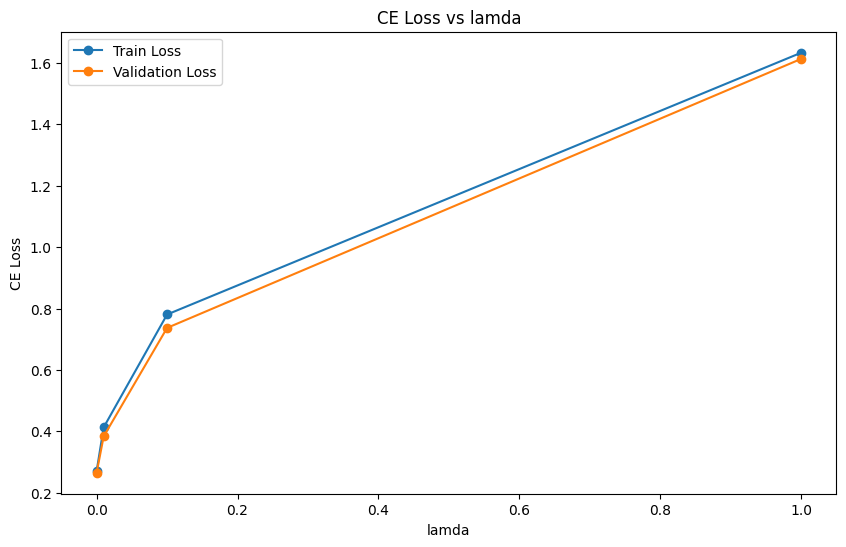

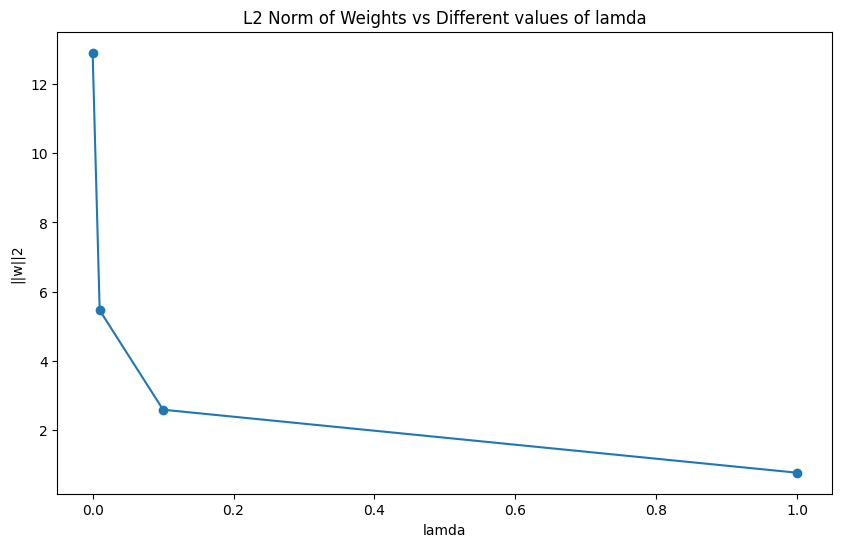

Best lamda: 0
Epoch [1/20], Test Loss: 0.3625
Epoch [2/20], Test Loss: 0.3226
Epoch [3/20], Test Loss: 0.3066
Epoch [4/20], Test Loss: 0.2979
Epoch [5/20], Test Loss: 0.2928
Epoch [6/20], Test Loss: 0.2873
Epoch [7/20], Test Loss: 0.2845
Epoch [8/20], Test Loss: 0.2818
Epoch [9/20], Test Loss: 0.2822
Epoch [10/20], Test Loss: 0.2790
Epoch [11/20], Test Loss: 0.2789
Epoch [12/20], Test Loss: 0.2773
Epoch [13/20], Test Loss: 0.2745
Epoch [14/20], Test Loss: 0.2751
Epoch [15/20], Test Loss: 0.2740
Epoch [16/20], Test Loss: 0.2724
Epoch [17/20], Test Loss: 0.2737
Epoch [18/20], Test Loss: 0.2715
Epoch [19/20], Test Loss: 0.2715
Epoch [20/20], Test Loss: 0.2730


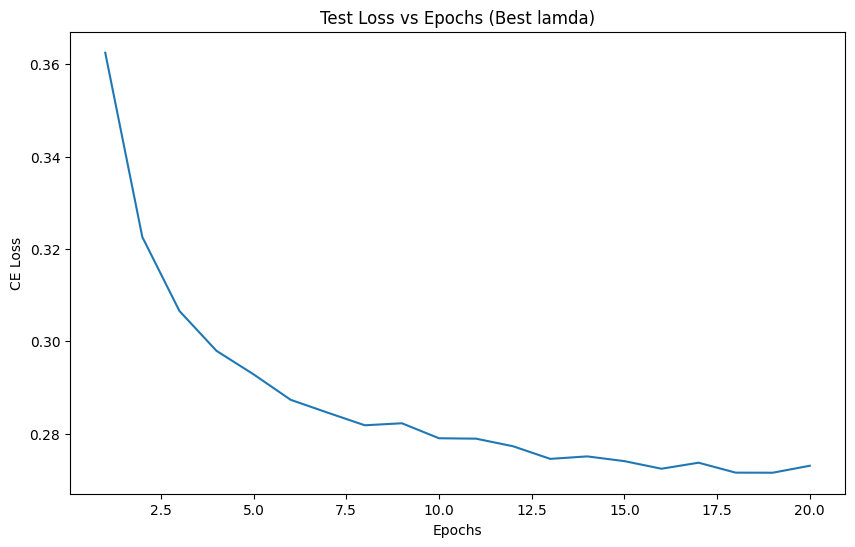

In [8]:
def main():
    # Hyperparameters
    input_size = 28 * 28  # 784, for flattened 28x28 MNIST images
    num_classes = 10  # Digits 0-9
    learning_rate = 0.01
    num_epochs = 20
    batch_size = 10  # Best batch size from (2)
    lambda_values = [0,0.01, 0.1, 1]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #(use GPU if available, otherwise CPU)

   # Load and preprocess data
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, 60000) #first split original data into trainset and testset
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 50000) #then split trainset into trainset and valset
    X_train, X_val, X_test = prepare_X(X_train), prepare_X(X_val), prepare_X(X_test)
    results = {} #Dictionary to store lamda, train loss, val loss and L2 norm of weights

    for lamda in lambda_values:
        print(f"Training with lamda = {lamda}")

        # Create the Datasets and DataLoaders
        trainset = TensorDataset(X_train, y_train)
        valset = TensorDataset(X_val, y_val)
        testset = TensorDataset(X_test, y_test)
        # Create the Dataloaders
        train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
        train_loader_eval = DataLoader(dataset=trainset, batch_size=1000, shuffle=False) #for evaluation, set large batchsize
        val_loader = DataLoader(dataset=valset, batch_size=1000, shuffle=False) #batchsize for validate set and test set doesn't affect
        test_loader = DataLoader(dataset=testset, batch_size=1000, shuffle=False) #training, set large batchsize to facilitate parallelism


        # Initialize model, loss function, and optimizer
        model = MLR(input_size, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lamda)
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate on train and validation sets
            model.eval()
            with torch.no_grad():
                train_loss = sum(criterion(model(X_train.to(device)), y_train.to(device)).item() for _ in range(1))
                val_loss = sum(criterion(model(X_val.to(device)), y_val.to(device)).item() for _ in range(1))
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


        w_norm = torch.norm(next(model.parameters())).item()  #L2 norm of weights
        results[lamda] =
            {'train_losses': train_losses,
            'val_losses': val_losses,
            'w_norm': w_norm }


    plot_results(results, lambda_values)
    # Train on whole training data with best lamda
    best_lamda = min(results, key=lambda x: results[x]['val_losses'][-1])
    print(f"Best lamda: {best_lamda}")

    # Train on whole training data (train + validation)
    X_full_train = torch.cat((X_train, X_val))
    y_full_train = torch.cat((y_train, y_val))
    full_trainset = TensorDataset(X_full_train, y_full_train)
    full_train_loader = DataLoader(dataset=full_trainset, batch_size=batch_size, shuffle=True)
    model = MLR(input_size, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=best_lamda)
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_loss = sum(criterion(model(X_test.to(device)), y_test.to(device)).item() for _ in range(1))
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')

    # Plot test loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), test_losses)
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
    plt.title('Test Loss vs Epochs (Best lamda)')
    plt.show()

def plot_results(results, lambda_values):
    # Plot CE loss vs lamda
    plt.figure(figsize=(10, 6))
    train_losses = [results[l]['train_losses'][-1] for l in lambda_values]
    val_losses = [results[l]['val_losses'][-1] for l in lambda_values]
    plt.plot(lambda_values, train_losses, 'o-', label='Train Loss')
    plt.plot(lambda_values, val_losses, 'o-', label='Validation Loss')
    plt.xlabel('lamda')
    plt.ylabel('CE Loss')
    plt.title('CE Loss vs lamda')
    plt.legend()
    plt.show()

    # Plot ||w||2 vs lamda
    plt.figure(figsize=(10, 6))
    w_norms = [results[l]['w_norm'] for l in lambda_values]
    plt.plot(lambda_values, w_norms, 'o-')
    plt.xlabel('lamda')
    plt.ylabel('||w||2')
    plt.title('L2 Norm of Weights vs Different values of lamda')
    plt.show()

if __name__ == "__main__":
    main()